# User Segmentation for Targeted Marketing

## Introduction
In this notebook, we will perform user segmentation on social media data. Our goal is to identify distinct groups of users based on their engagement patterns, which will enable targeted marketing strategies. We'll use clustering techniques to segment users, assuming that we have access to engagement metrics such as follower counts, post frequencies, and engagement rates.

## Setup
First, we import necessary libraries and set up database connectivity using the `PostgresDatabase` class.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from sklearn.cluster import KMeans

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

sns.set()
warnings.simplefilter(action='ignore', category=FutureWarning)


# Ensure that the plots are displayed inside the notebook
%matplotlib inline

In [2]:
from packages.database_util import PostgresDatabase

# Initialize database connection using credentials
db = PostgresDatabase(
    host='postgres',
    port=5432,
    database='ope_market',
    user='postgres',
    password='postgres'
)

## Data Collection
We collect user data from our database, focusing on metrics that could influence segmentation like `followers`, `following`, `posts`, and `engagement`.


In [3]:
query = """
SELECT 
    u.datasource_id, 
    u.location, 
    u.links, 
    u.description, 
    t.followers, 
    t.following, 
    t.posts, 
    t.likes,
    CASE WHEN u.verified then 1 else 0 end as verified
FROM 
    public.users u
JOIN 
    public.twitter_stats t ON u.datasource_id = t.user_id
"""
users_data = db.fetch_data(query)


In [4]:
# Check for null values across all columns
print(users_data.isnull().sum())

datasource_id          0
location               0
links                  0
description      1367806
followers              0
following              0
posts                  0
likes                  0
verified               0
dtype: int64


## Feature Engineering and Calculation of Engagement and Influence
Before we segment the users, we'll engineer additional features that can help in our analysis. We'll also calculate engagement and influence metrics based on existing data.


In [5]:
try:
    # Feature engineering for binary columns
    users_data['has_location'] = users_data['location'].notna().astype(int)
    users_data['has_links'] = users_data['links'].notna().astype(int)
    users_data['has_description'] = users_data['description'].notna().astype(int)
    users_data.drop(['location', 'links', 'description'], axis=1, inplace=True)
except KeyError:
    pass

# Safe division function to handle division by zero
def safe_divide(numerator, denominator, epsilon=1e-8):
    return numerator / (denominator + epsilon)

# Calculate Likes per Post safely
users_data['likes_per_post'] = users_data.apply(lambda row: safe_divide(row['likes'], row['posts']), axis=1)

# Define Engagement using safe division
users_data['engagement'] = users_data.apply(
    lambda row: safe_divide(row['likes_per_post'], (row['following'] + 1)) * row['followers'], axis=1)

# Define Influence as a product of followers and their engagement
users_data['influence'] = users_data.apply(
    lambda row: row['followers'] * row['engagement'], axis=1)



## Data Normalization and Scaling
We need to standardize our data to ensure that our clustering algorithm performs optimally and fairly across all features.


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features = ['followers', 'following', 'posts', 'likes', 'engagement', 'influence', 'has_location', 'has_links', 'has_description', 'verified']
users_data_scaled = scaler.fit_transform(users_data[features])


## Clustering
Using K-means clustering, we segment our users based on the newly engineered features and their engagement metrics.


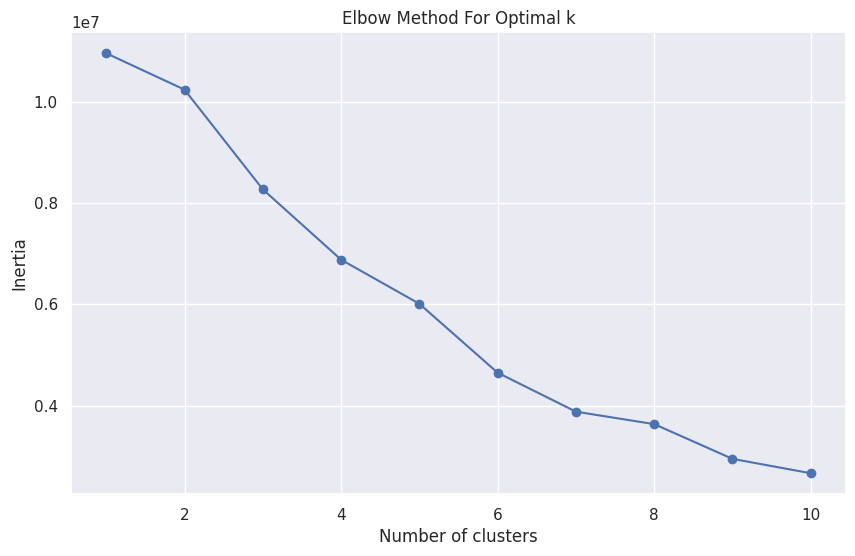

In [7]:
# Optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(users_data_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()



## Elbow Method Analysis for Determining Optimal Number of Clusters

The Elbow Method is utilized here to determine the optimal number of clusters for K-means clustering. This method involves plotting the sum of squared distances of samples to their closest cluster center, which is known as inertia. The goal is to identify the point where the inertia begins to decrease more slowly, forming an "elbow".

From the plot, we can observe the following:
- The inertia rapidly decreases from 1 to 3 clusters, suggesting significant improvement in cluster cohesion within this range.
- Beyond 3 clusters, the rate of decrease in inertia slows down substantially, indicating diminishing returns on further increasing the number of clusters.

### Decision:
Based on the elbow plot, the optimal number of clusters for this analysis is **3**. This choice balances complexity and adequacy, providing a reasonable segmentation of the data without overfitting. Clustering beyond this point would likely lead to over-segmentation with minimal gain in performance or interpretability.


In [8]:
# Clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(users_data_scaled)
users_data['Cluster'] = clusters


## Visualization of Clusters
Attempt to visualize clusters using pairplot or alternative methods if issues arise.


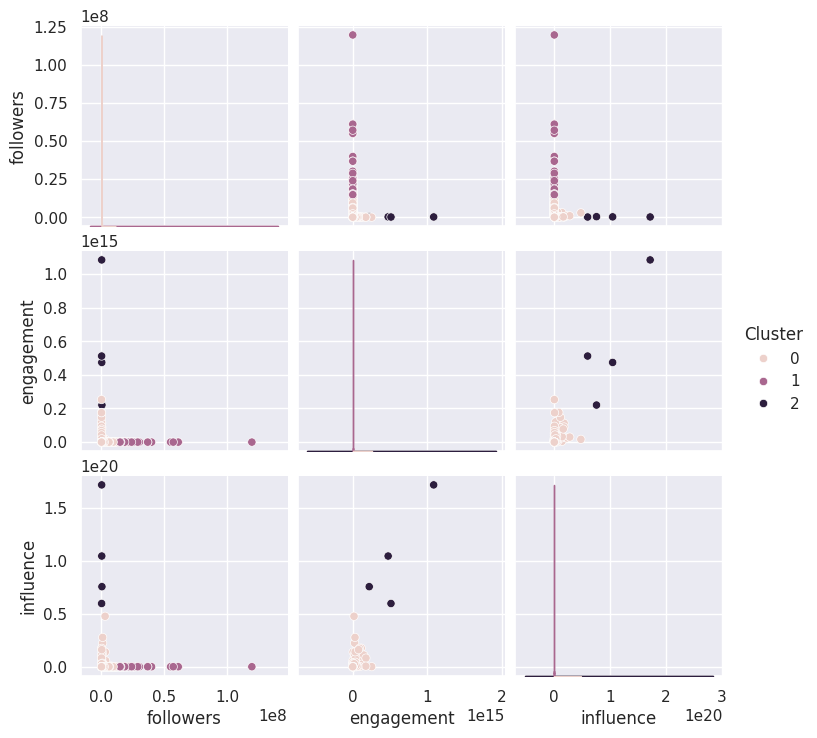

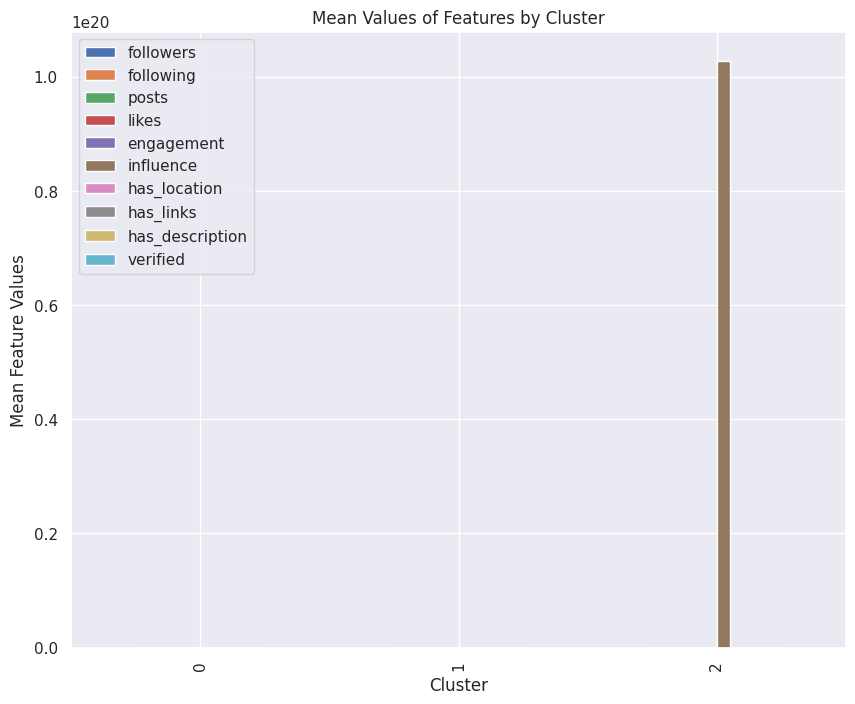

In [9]:
# Run time is long

# Sample a subset of the data for visualization if the full dataset is too large
# takes too long locally so I just look at a subset :)
# sampled_data = users_data.sample(frac=0.1, random_state=42)  # Adjust the fraction as necessary
# sns.pairplot(sampled_data, hue='Cluster', vars=features)
# plt.show()

# Or use simplified visualization
subset_features = ['followers', 'engagement', 'influence']  # Select fewer features for clarity and performance
sns.pairplot(users_data, hue='Cluster', vars=subset_features)
plt.show()

# If the kernel still dies, consider plotting aggregate statistics
cluster_means = users_data.groupby('Cluster')[features].mean()
cluster_means.plot(kind='bar', figsize=(10, 8))
plt.title('Mean Values of Features by Cluster')
plt.ylabel('Mean Feature Values')
plt.xlabel('Cluster')
plt.show()


### Observations:

1. **Followers vs. Engagement:**
   - **Cluster 0 (light pink)**: Mostly low engagement across all levels of followers.
   - **Cluster 1 (salmon)**: Moderate to high engagement, typically with fewer followers.
   - **Cluster 2 (black)**: High engagement, particularly visible at higher follower counts.

2. **Followers vs. Influence:**
   - **Cluster 0**: Lower influence across the board, independent of follower count.
   - **Cluster 1**: Generally low influence but some points with moderate influence at lower follower counts.
   - **Cluster 2**: Moderate to high influence, more apparent at higher follower counts.

3. **Engagement vs. Influence:**
   - **Cluster 0**: Low engagement and low influence.
   - **Cluster 1**: Moderate to high engagement with low to moderate influence.
   - **Cluster 2**: High engagement with moderate to high influence.

### Analysis:
- **Cluster 0** represents a group with low influence and engagement, suggesting these might be less active or less popular accounts.
- **Cluster 1** shows a pattern of higher engagement relative to their follower count and moderate influence, possibly indicating these are highly interactive accounts with a dedicated but smaller audience.
- **Cluster 2** is characterized by high follower counts, engagement, and influence, suggesting these are possibly celebrity or high-profile influencer accounts.




### Observations:

1. **Cluster 0**:
   - Low average values across most metrics.
   - Minimal engagement and influence, low followers, posts, and likes.
   - Almost no verified accounts.

2. **Cluster 1**:
   - Moderate mean values for most metrics.
   - Higher engagement and influence than Cluster 0.
   - Presence of location, links, and description features.

3. **Cluster 2**:
   - High mean values for all features, especially verification.
   - High values for followers, posts, likes, engagement, and influence.
   - High rate of verification, indicating high-profile users.

### Analysis:

- **Cluster 0** likely represents less popular or newer users with limited activity.
- **Cluster 1** includes moderately active users, possibly growing influencers or small businesses.
- **Cluster 2** likely includes celebrities or top influencers, evident from high metrics and verification rates.

These insights can help develop targeted strategies for marketing or content delivery based on user segment characteristics.
